In [33]:
# from albumentations import augmentations
# import albumentations.augmentations as A
import albumentations as A

import os
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image

from utils_.visum_utils import VisumData
from utils_ import transforms as T

In [2]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(augmentations.transforms.Blur())
    return T.Compose(transforms)

for each in  VisumData('../../../visum_data/train', modality='rgb', transforms=get_transform(train=True)):
    print (' - name : ', each[2], each[0].shape)
    rgb_nir = each[0].repeat(3,1,1)
    plt.imshow(np.rollaxis(rgb_nir.numpy(),0,3))
    plt.title('Name - {0}'.format(each[2]))
    plt.show()
    break

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

# Albu

In [12]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)
# The coco format of a bounding box looks like [x_min, y_min, width, height], e.g. [97, 12, 150, 200].
# The pascal_voc format of a bounding box looks like [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'pascal_voc', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

BOX_COLOR_TRUE = (0, 255, 0)
BOX_COLOR_PRED = (255, 0, 0)
TEXT_COLOR_TRUE = (0, 0, 0)

# csv_file = [img_name, x_min, x_max, y_min, y_max, class, conf]
def getannotations(csv_file, dir_images):
    annotations = {}
    with open(csv_file, 'r') as fp:
        for i, row in enumerate(fp.readlines()):
            row_tmp = row.split(',')
            image_file = str(row_tmp[0])
            x_min = float(row_tmp[1])
            y_min = float(row_tmp[2])
            x_max = float(row_tmp[3])
            y_max = float(row_tmp[4]) 
            class_ = int(row_tmp[5])
            try:
                conf = float(row_tmp[6])
            except:
                pass
            if image_file in annotations:
                annotations[image_file]['bboxes'].append([x_min, y_min, x_max, y_max])
                annotations[image_file]['category_id'].append(class_)
            else:
                image_path = os.path.join(dir_images, image_file)
                annotations[image_file] = {'image_name' : image_file,'image' : image_path, 'bboxes' : [[x_min, y_min, x_max, y_max]], 'category_id' : [class_]}

    return annotations

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color_box, color_text, thickness=2):
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color_box, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color_box, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_text, lineType=cv2.LINE_AA)
    return img

def visualize(annotations_true, category_id_to_name, save_dir=''):

    if (1):
        if isinstance(annotations_true['image'], str):
            img_true = cv2.imread(annotations_true['image'])
        else:
            img_true = annotations_true['image']
        for idx, bbox in enumerate(annotations_true['bboxes']):
            img_true = visualize_bbox(img_true, bbox, annotations_true['category_id'][idx], category_id_to_name, BOX_COLOR_TRUE, TEXT_COLOR_TRUE)
        
    
    f,axarr = plt.subplots(1, figsize=(10,10))
    axarr.imshow(img_true)
    axarr.set_title('Ground Truth')
    axarr.set_xticks([])
    axarr.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    if len(save_dir):
        plt.savefig('{0}/{1}'.format(save_dir, annotations_pred['image_name'].split('.')[0] + '.png'), bbox_inches = 'tight',pad_inches = 0, format='png')
    plt.close()

In [21]:
# annotations = {'image': image, 'bboxes': [[366.7, 80.84, 132.8, 181.84], [5.66, 138.95, 147.09, 164.88]], 'category_id': [18, 17]}
if (1):
    dir_images    = '../../../visum_data/train'
    csv_file_true = '../../../visum_data/train/annotation.csv'
    category_id_to_name = {
                    0: 'book', 1: 'bottle', 2: 'box', 3: 'cellphone',
                    4: 'cosmetics', 5: 'glasses', 6: 'headphones', 7: 'keys',
                    8: 'wallet', 9: 'watch', -1: 'n.a.'}
    plot_dir = ''

if(1): 
    annotations_images_true = getannotations(csv_file_true, dir_images)
    print (' - [Plot] Finished reading annotations - true :  {0}'.format(csv_file_true))
#     for i,image in enumerate(annotations_images_true):
#         print (image)
#         annotations_image_true = annotations_images_true[image]
#         print (annotations_image_true)
#         print (' - orig : ', annotations_image_true['bboxes'])
        
#         if (1):
#             pass
#             aug = get_aug([])
#             # aug = get_aug([VerticalFlip(p=1)])
#             # aug = get_aug([augmentations.transforms.Blur()])
#             # aug = get_aug([CenterCrop(p=1, height=100, width=400)], min_visibility=0.8)
#             # aug = albumentations.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
        
#         # annotations_image_true['image'] = cv2.imread(annotations_image_true['image'])
#         # annotations_image_true['image'] = io.imread(annotations_image_true['image'])
#         annotations_image_true['image'] = np.array(Image.open(annotations_image_true['image']))
        
#         augmented = aug(**annotations_image_true)
#         print (' - aug  : ', augmented['bboxes'])
#         print (' - aug  : ', augmented['image'].shape)
#         visualize(augmented, category_id_to_name, save_dir=plot_dir)
        break

IndentationError: unexpected indent (<ipython-input-21-8d93e18bfe45>, line 36)

In [31]:
def vanya(image, augs):
    annotations_image_true = dict(annotations_images_true[image])
    print (' - orig : ', annotations_image_true['bboxes'])

    if (1):
        pass
        aug = get_aug(augs)
        # aug = get_aug([VerticalFlip(p=1)])
        # aug = get_aug([augmentations.transforms.Blur()])

    annotations_image_true['image'] = np.array(Image.open(annotations_image_true['image']))
    augmented = aug(**annotations_image_true)
    visualize(augmented, category_id_to_name, save_dir=plot_dir)

In [184]:
import random
dark_img = 'RGB0303X.jpg'
medium_img = 'RGB0334X.jpg'
light_img = 'RGB0306X.jpg'
random_img = lambda: random.choice(list(annotations_images_true.keys()))
print (random_img())

DEFAULT_AUGMENTATIONS = [
    A.HorizontalFlip(0.5),
    A.OneOf([
        A.Blur(p=0.5, blur_limit=5),
        A.MedianBlur(p=0.5, blur_limit=4),
        A.MotionBlur(p=0.5, blur_limit=4),
    ]),
    A.HueSaturationValue(p=0.4, hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15),
    A.RGBShift(p=0.5),
    A.GaussNoise(p=0.5),
    A.CLAHE(p=0.2, tile_grid_size=(8, 8)),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.03, rotate_limit=5, scale_limit=0.05),
    A.JpegCompression(p=0.5)
]

RGB1116X.jpg


 - orig :  [[316.0, 333.0, 367.0, 365.0], [157.0, 336.0, 176.0, 355.0]]


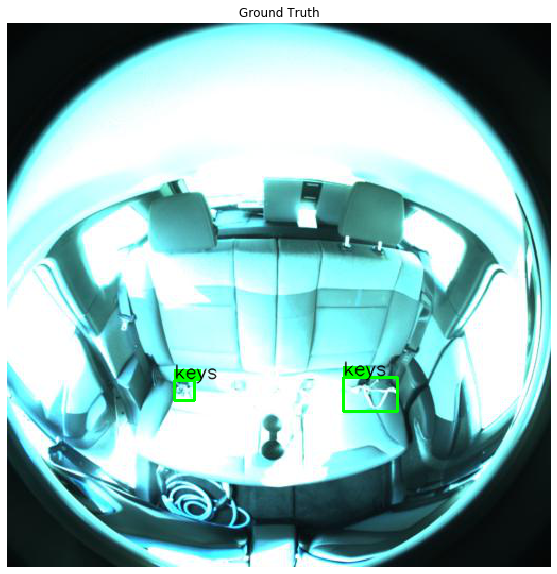

 - orig :  [[316.0, 333.0, 367.0, 365.0], [157.0, 336.0, 176.0, 355.0]]


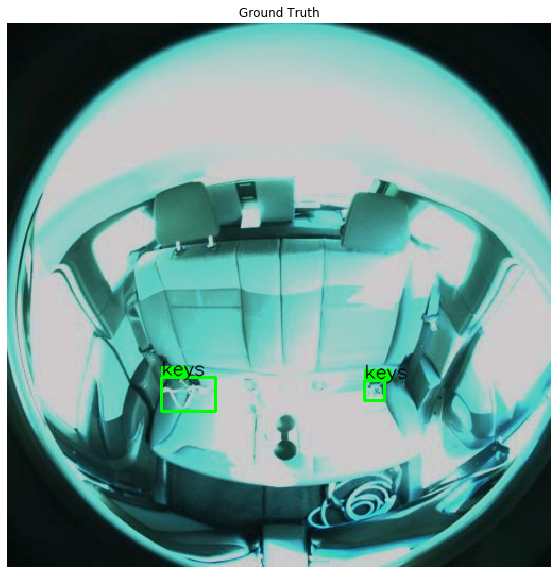

In [207]:
annotations_images_true = getannotations(csv_file_true, dir_images)
vanya(light_img, [])
vanya(light_img, DEFAULT_AUGMENTATIONS)

In [ ]:
aug = get_aug([])
augmented = aug(**annotations_image_true)
visualize(augmented, category_id_to_name, save_dir=plot_dir)